# Анализ ежедневного потребления и производства «зеленой» энергии в Австрии за период с 2015 по 2020 год

In [1]:
### General import
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [2]:
# Read input file
df = pd.read_csv('opsd_austria_daily.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,Electricity_consumption,Wind_production,Solar_production,Price,Wind+Solar
Date,,,,,
2015-01-01 00:00:00+00:00,151.030,3.930,NaN,1.001,NaN
2015-01-02 00:00:00+00:00,138.923,17.151,0.279,0.739,17.430
2015-01-03 00:00:00+00:00,130.691,15.712,0.321,0.468,16.033
2015-01-04 00:00:00+00:00,125.123,37.943,0.224,0.330,38.167
2015-01-05 00:00:00+00:00,162.381,35.963,0.276,0.931,36.239


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2100 entries, 2015-01-01 00:00:00+00:00 to 2020-09-30 00:00:00+00:00
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Electricity_consumption  2100 non-null   float64
 1   Wind_production          2096 non-null   float64
 2   Solar_production         2094 non-null   float64
 3   Price                    1362 non-null   float64
 4   Wind+Solar               2094 non-null   float64
dtypes: float64(5)
memory usage: 98.4 KB


Набор данных содержит значения ежедневного потребления энергии и ее производства с помощью ветровых установок и солнечных панелей в течение 2015–2020 годов и даты:
* Date: Дата в формате year-month-day.
* Electricity_consumption: Потребление электричества в ГВт∙ч.
* Wind_production: Производство ветровой энергии в ГВт∙ч.
* Solar_production: Производство солнечной энергии в ГВт∙ч.
* Price: Спотовая цена2 на электроэнергию для Австрии в евро за 1 кВт∙ч.
* Wind+Solar: Сумма ветровой и солнечной энергии в ГВт∙ч.

## Задание 1

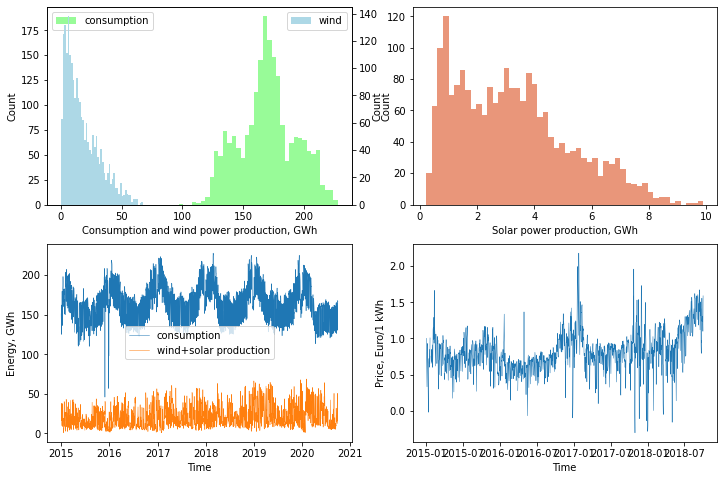

In [5]:
# Task 1a: visualize distribution & time changes of input data
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Distribution of electricity consumption & wind production
ax[0,0].hist(df['Electricity_consumption'], bins=50, color='palegreen', label='consumption')
ax[0,0].set_xlabel('Consumption and wind power production, GWh')
ax[0,0].set_ylabel('Count')
ax2 = ax[0,0].twinx()
ax2.hist(df['Wind_production'], bins=50, color='lightblue', label='wind')
ax2.set_ylabel('Count')
ax[0,0].legend(loc='best')
ax2.legend(loc='best')

# Distribution of solar power production
ax[0,1].hist(df['Solar_production'], bins=50, color='darksalmon')
ax[0,1].set_xlabel('Solar power production, GWh')
ax[0,1].set_ylabel('Count')

# Time series
ax[1,0].plot(df['Electricity_consumption'], linewidth = 0.5, label='consumption')
ax[1,0].plot(df['Wind_production']+df['Solar_production'], linewidth = 0.5, label='wind+solar production')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Energy, GWh')
ax[1,0].legend(loc='best')

# Price distribution
ax[1,1].plot(df['Price'], linewidth = 0.5)
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('Price, Euro/1 kWh')
plt.show()

In [6]:
# Task 1b: analysing the seasonality for 2019 year
''' defining a rolling average '''
df['Electricity_consumption_RA'] = df['Electricity_consumption'].rolling(15).mean()
df['Wind_production_RA'] = df['Wind_production'].rolling(15).mean()
df['Solar_production_RA'] = df['Solar_production'].rolling(15).mean()

start_date = '2019-01-01 00:00:00+00:00'
end_date = '2019-12-31 00:00:00+00:00'

<AxesSubplot:title={'center':'Electricity_consumption_RA in 2019'}, xlabel='Date', ylabel='GWh'>

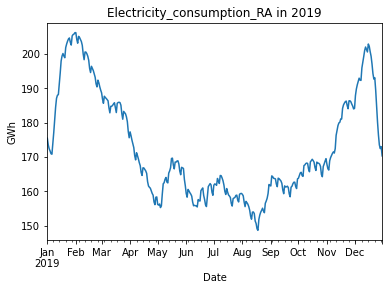

In [7]:
df.loc[start_date:end_date]['Electricity_consumption_RA'].plot(
    title='Electricity_consumption_RA in 2019',
    ylabel='GWh',
    xlabel='Date',
)

<AxesSubplot:title={'center':'Wind_production_RA in 2019'}, xlabel='Date', ylabel='GWh'>

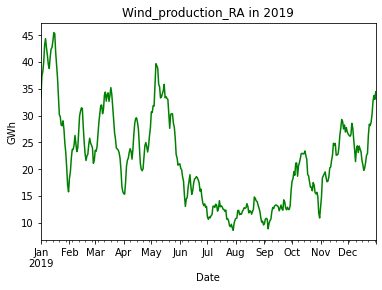

In [8]:
df.loc[start_date:end_date]['Wind_production_RA'].plot(
    title='Wind_production_RA in 2019',
    ylabel='GWh',
    xlabel='Date',
    color='green'
)

<AxesSubplot:title={'center':'Solar_production_RA in 2019'}, xlabel='Date', ylabel='GWh'>

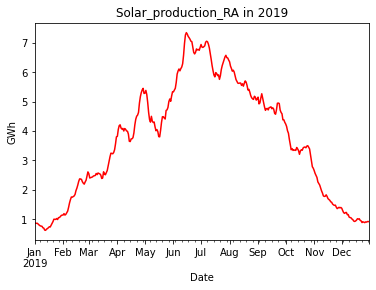

In [9]:
df.loc[start_date:end_date]['Solar_production_RA'].plot(
    title='Solar_production_RA in 2019',
    ylabel='GWh',
    xlabel='Date',
    color='red'
)

### Выводы по Заданию 1

Потребление электроэнергии в летние месяцы значительно снижается (менее 150 ГВт в сутки в августе), при этом уровень потребления в зимние месяцы до полутора раз выше (более 200 ГВт). Производство энергии ветряными электростанции довольно волатильно и непредсказуемо - уровень производства варьируется в диапазоне 10-45 ГВт (особенно критичный период - июль-сентбрь, когда производство не превышает 15 ГВт). Солнечная энергия вносит наименьший вклад в части производства электроэнергии - в летние месяцы стоит ожидать до 7 ГВт в сутки; колебания в зимние месяцы - в пределах 1-2 ГВт.

## Задание 2

In [10]:
# read input
df = pd.read_csv('opsd_austria_daily.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

In [11]:
df.head()

,Date,Electricity_consumption,Wind_production,Solar_production,Price,Wind+Solar,Year,Month
0,2015-01-01 00:00:00+00:00,151.030,3.930,NaN,1.001,NaN,2015,1
1,2015-01-02 00:00:00+00:00,138.923,17.151,0.279,0.739,17.430,2015,1
2,2015-01-03 00:00:00+00:00,130.691,15.712,0.321,0.468,16.033,2015,1
3,2015-01-04 00:00:00+00:00,125.123,37.943,0.224,0.330,38.167,2015,1
4,2015-01-05 00:00:00+00:00,162.381,35.963,0.276,0.931,36.239,2015,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   Date                     2100 non-null   datetime64[ns, UTC]
 1   Electricity_consumption  2100 non-null   float64            
 2   Wind_production          2096 non-null   float64            
 3   Solar_production         2094 non-null   float64            
 4   Price                    1362 non-null   float64            
 5   Wind+Solar               2094 non-null   float64            
 6   Year                     2100 non-null   int64              
 7   Month                    2100 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(2)
memory usage: 131.4 KB


In [13]:
df.isna().sum()

Date                         0
Electricity_consumption      0
Wind_production              4
Solar_production             6
Price                      738
Wind+Solar                   6
Year                         0
Month                        0
dtype: int64

In [14]:
# data imputation
def clean(dataset, columns):
    dataset[columns].replace(0, np.nan, inplace=True)
    dataset[columns].fillna(method='backfill', inplace=True) # choose a scheme for fillna
    
# call a clean function here for Electricity_consumption, Wind_production columns
clean(df, 'Electricity_consumption') # no nan-values
clean(df, 'Wind_production')

In [15]:
df.isna().sum()

Date                         0
Electricity_consumption      0
Wind_production              0
Solar_production             6
Price                      738
Wind+Solar                   6
Year                         0
Month                        0
dtype: int64

RMSE: 18.729532
MAE: 16.902106


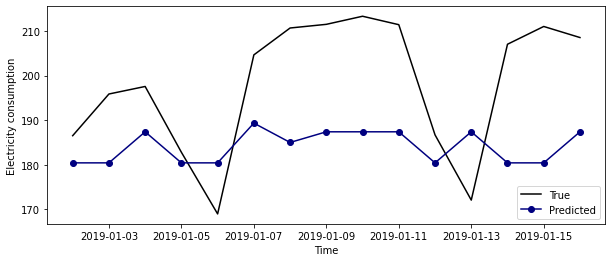

In [16]:
# ensemble learning for regression
def ensemble_training(df_train, df_test):
    label = 'Electricity_consumption'
    X_train = df_train.drop(label, axis=1)
    y_train = df_train.loc[:, label]
    X_test = df_test.drop(label, axis=1)
    y_test = df_test.loc[:, label]
    dtrab = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5),
                              # check which value for max_depth gives better RMSE/MSE: 5, 10, 15, 20, 25
                              n_estimators=10,
                              # check which value for n_estimators gives better RMSE/MAE: 10, 20, 30, 40, 50, 100
                              random_state=1)
    dtrab.fit(X_train, y_train)
    y_predict = dtrab.predict(X_test)
    print('RMSE: %.6f' % (sqrt(mean_squared_error(y_test, y_predict))))
    print('MAE: %.6f' % (mean_absolute_error(y_test, y_predict)))
    df_sol = pd.DataFrame({'True': np.array(y_test),'Predicted': np.array(y_predict)})
    return dtrab, df_sol

features = ['Electricity_consumption', 'Wind_production', 'Month']
df_train = df.loc[df['Year']!=2019, features]
df_test = df.loc[df['Year']==2019, features]

def month_select(df, column):
    df_dummy = pd.get_dummies(df[column], prefix='M')
    df_new = pd.concat([df, df_dummy], axis=1)
    df_new = df_new.drop(column, axis=1)
    return df_new

df_train = month_select(df_train, 'Month')
df_test = month_select(df_test, 'Month')

df_sol = []
model, df_sol = ensemble_training(df_train, df_test)
df_sol = pd.concat([df_sol.reset_index(drop=True), 
                    pd.Series(df.loc[df['Year']==2019, 'Date']).reset_index(drop=True)], axis=1)

# visualization
fig,ax = plt.subplots(figsize=(10,4))
ax.plot_date(df_sol.loc[1:15,'Date'],
             df_sol.loc[1:15,'True'],
             marker='None',
             linestyle = '-',
             color='black', label='True')
ax.plot_date(df_sol.loc[1:15,'Date'],
             df_sol.loc[1:15,'Predicted'],
             marker='o',
             linestyle = '-',
             color='navy', markeredgecolor='navy', label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Electricity consumption')
ax.legend(loc='lower right')
plt.show()

### Подбор гиперпараметров - GridSearchCV

In [17]:
features = ['Electricity_consumption', 'Wind_production', 'Month']

df_train = df.loc[df['Year']!=2019, features]
df_test = df.loc[df['Year']==2019, features]

df_train = month_select(df_train, 'Month')
df_test = month_select(df_test, 'Month')

label = 'Electricity_consumption'
X_train = df_train.drop(label, axis=1)
y_train = df_train.loc[:, label]
X_test = df_test.drop(label, axis=1)
y_test = df_test.loc[:, label]

In [18]:
abc = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=1)

parameters = {'base_estimator__max_depth':[5, 10, 15, 20, 25],
              'n_estimators':[10, 20, 30, 40, 50, 100]}

clf = GridSearchCV(abc, parameters, verbose=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)
print('RMSE: %.6f' % (sqrt(mean_squared_error(y_test, y_predict))))
print('MAE: %.6f' % (mean_absolute_error(y_test, y_predict)))
print('Best Parameters:', clf.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
RMSE: 18.729532
MAE: 16.902106
Best Parameters: {'base_estimator__max_depth': 5, 'n_estimators': 10}


In [19]:
abc = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=1)

parameters = {'base_estimator__max_depth':[5, 10, 15, 20, 25],
              'n_estimators':[10, 20, 30, 40, 50, 100]}

clf = GridSearchCV(abc, parameters, verbose=3, scoring='neg_mean_absolute_error', n_jobs=-1)
clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)
print('RMSE: %.6f' % (sqrt(mean_squared_error(y_test, y_predict))))
print('MAE: %.6f' % (mean_absolute_error(y_test, y_predict)))
print('Best Parameters:', clf.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
RMSE: 18.729532
MAE: 16.902106
Best Parameters: {'base_estimator__max_depth': 5, 'n_estimators': 10}


### Выводы по Заданию 2

С увеличением max_depth и n_estimators модель все сильнее подстраивается под тестоввые данные. Существует опасность переобучения модели на заданной выборке и, как следствие, ее неспособности давать качественные предсказания на новых данных. Целесообразно выбрать для имеющейся выборки минимальный max_depth и n_estimators.

Инструменты для подбора гиперпараметров моделей (такие, как GridSearchCV) озвполяют существенно оптимизировать трудовые и временные затраты на подготовку моделей.

## Задание 3

In [20]:
# read input
data = pd.read_csv('opsd_austria_daily.csv', index_col=0)
data.index = pd.to_datetime(data.index)

start_date = '2015-01-01 00:00:00+00:00'
end_date = '2018-09-30 00:00:00+00:00' # no prices for latest dates

data = data.loc[start_date:end_date]

cols = list(data.columns)
for col in cols:
    clean(data, col)
    
data.isna().sum()

Electricity_consumption    0
Wind_production            0
Solar_production           0
Price                      0
Wind+Solar                 0
dtype: int64

In [21]:
# check
print('Начало наблюдений:', data.index[0])
print('Конец наблюдений:', data.index[-1])

Начало наблюдений: 2015-01-01 00:00:00+00:00
Конец наблюдений: 2018-09-30 00:00:00+00:00


In [22]:
# new features
data['Delta'] = data['Electricity_consumption'] - (data['Wind_production'] + data['Solar_production'])
data['Delta_Price'] = data['Price'] * data['Delta']*1000 # GWh to KWh

# updated dataset to csv
data.to_csv('opsd_austria_daily_updated.csv')
data.sample(5)

,Electricity_consumption,Wind_production,Solar_production,Price,Wind+Solar,Delta,Delta_Price
Date,,,,,,,
2018-08-18 00:00:00+00:00,143.211,1.197,6.145,1.250,7.342,135.869,169836.250
2017-05-03 00:00:00+00:00,176.071,3.267,4.157,0.796,7.424,168.647,134243.012
2015-09-11 00:00:00+00:00,150.593,4.646,3.203,0.772,7.849,142.744,110198.368
2016-06-24 00:00:00+00:00,169.247,8.923,4.569,0.726,13.492,155.755,113078.130
2017-03-16 00:00:00+00:00,185.835,20.715,3.303,0.821,24.018,161.817,132851.757


### Выводы по Заданию 3

In [23]:
yearly_prod_potential = round(data['Delta'].sum() / len(data) * 365, 1)
print('Потенциальный объем рынка электроэнергии ГВт/год - {}'.format(yearly_prod_potential))

yearly_market_potential = round(data['Delta_Price'].sum() / len(data) * 365 / 1000000, 1)
print('Потенциальный объем рынка электроэнергии млн. евро/год - {}'.format(yearly_market_potential))

Потенциальный объем рынка электроэнергии ГВт/год - 55170.2
Потенциальный объем рынка электроэнергии млн. евро/год - 46.1
